In [255]:
# Dependencies
import os
import json
from pprint import pprint

import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

In [2]:
# Import the station info json file. 
with open(os.path.join('data', 'station_info.json')) as jsonfile:
    station_info_json = json.load(jsonfile)

In [3]:
# How many bike stations are there in total?
station_ids_todate = [int(station['station_id']) for station in station_info_json]
print(f'There are currently {len(station_ids_todate)} stations in the system.')

There are currently 655 stations in the system.


In [4]:
# Import the ridership CSV file.
df = pd.read_csv(os.path.join('data', 'bst_ridership_2022.csv'))

In [5]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4620469 entries, 0 to 4620468
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Trip Id             4620469 non-null  int64  
 1   Trip  Duration      4620469 non-null  int64  
 2   Start Station Id    4620469 non-null  int64  
 3   Start Time          4620469 non-null  object 
 4   Start Station Name  4437003 non-null  object 
 5   End Station Id      4619190 non-null  float64
 6   End Time            4620469 non-null  object 
 7   End Station Name    4435503 non-null  object 
 8   Bike Id             4620469 non-null  int64  
 9   User Type           4620469 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 352.5+ MB


# Stage 1: Data Type Conversions

In [6]:
df_1 = df.copy()
# Each trip is marked by a unqiue `Trip Id`, which means that the column can be simply dropped.
print(df_1['Trip Id'].nunique() == len(df_1['Trip Id']))
df_1.drop(columns=['Trip Id'], inplace=True)

True


In [7]:
# Convert `Start Time` and `End Time` to datetime objects for easier downstream data manipulation.
df_1['Start Time'] = pd.to_datetime(df_1['Start Time'])
df_1['End Time'] = pd.to_datetime(df_1['End Time'])

In [8]:
# `End Station Id` should be of int64 type like `Start Station Id` but it's of float64 due to the presence of NaNs when read.
df_1['End Station Id'] = df_1['End Station Id'].astype('Int64')

In [9]:
# Reorder the columns.
df_1 = df_1.iloc[:, [2,5,0,1,3,4,6,7,8]]

In [307]:
df_1.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4620469 entries, 0 to 4620468
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   Start Time          4620469 non-null  datetime64[ns]
 1   End Time            4620469 non-null  datetime64[ns]
 2   Trip  Duration      4620469 non-null  int64         
 3   Start Station Id    4620469 non-null  int64         
 4   Start Station Name  4437003 non-null  object        
 5   End Station Id      4619190 non-null  Int64         
 6   End Station Name    4435503 non-null  object        
 7   Bike Id             4620469 non-null  int64         
 8   User Type           4620469 non-null  object        
dtypes: Int64(1), datetime64[ns](2), int64(3), object(3)
memory usage: 321.7+ MB


# Stage 2: Outliers in Trip Duration
We need to eliminate obvious outliers for `Trip Duration`, such as those with 0 sec duration.

In [309]:
df_2 = df_1.copy()

# Rmove the substring `Member` in each record of `User Type`.
df_2['User Type'] = df_1['User Type'].str.replace(' Member', '')

# Change `Trip Duration` to `Duration`.
df_2.rename(columns={'Trip  Duration': 'Duration'}, inplace=True)

# Limit the trip length to 1 day (1440 minutes), also removing those with less than 1 min duration.
df_2 = df_2[(df_2['Duration']>=60) & (df_2['Duration']<=(60*60*24))]
print(f"{len(df_1)-len(df_2)} records are removed.")

10834 records are removed.


In [310]:
# # Compute the typical outlier detectors.
# q1 = df_2['Duration'].quantile(0.25)
# q3 = df_2['Duration'].quantile(0.75)
# iqr = q3 - q1
# print(f'q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}')

# outliers = df_2['Duration']>(q3+1.5*iqr)
# # Note that q1-1.5*iqr is negative, so it's not included in the computation.
# df_2[~outliers] # Can assign to df_2 if this approach is used.

# # The way the distribution for casual members trails off here looks like information lost more than outlier removal.
# # As such, the quantiles can be determined and the outliers removed for each group.
# df_2[~outliers][df_2[~outliers]['User Type'] == 'Casual']['Duration'].hist(bins=30)
# plt.xlim([0, q3+1.5*iqr])

# # Compute the outliers for annual members.
# df_2_annual = df_2[df_2['User Type'] == 'Annual Member']
# q1 = df_2_annual['Duration'].quantile(0.25)
# q3 = df_2_annual['Duration'].quantile(0.75)
# iqr = q3 - q1
# print(f'Annual Members: q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}')
# df_2_annual = df_2_annual[~(df_2_annual['Duration']>(q3+1.5*iqr))]

# # Compute the outliers for casual members.
# df_2_casual = df_2[df_2['User Type'] == 'Casual Member']
# q1 = df_2_casual['Duration'].quantile(0.25)
# q3 = df_2_casual['Duration'].quantile(0.75)
# iqr = q3 - q1
# print(f'Casual Members: q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}')
# df_2_casual = df_2_casual[~(df_2_casual['Duration']>(q3+1.5*iqr))]

# pd.concat([df_2_annual, df_2_casual]) # Can assign to df_2 if this approach is used.

In [311]:
df_2.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4609635 entries, 0 to 4620468
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   Start Time          4609635 non-null  datetime64[ns]
 1   End Time            4609635 non-null  datetime64[ns]
 2   Duration            4609635 non-null  int64         
 3   Start Station Id    4609635 non-null  int64         
 4   Start Station Name  4426570 non-null  object        
 5   End Station Id      4609602 non-null  Int64         
 6   End Station Name    4426353 non-null  object        
 7   Bike Id             4609635 non-null  int64         
 8   User Type           4609635 non-null  object        
dtypes: Int64(1), datetime64[ns](2), int64(3), object(3)
memory usage: 356.1+ MB


## `User Type`

In [312]:
df_2['User Type'].value_counts()

Casual    2872858
Annual    1736777
Name: User Type, dtype: int64

In [313]:
df_2.groupby('User Type')['Duration'].mean()

User Type
Annual     700.816806
Casual    1064.046363
Name: Duration, dtype: float64

In [314]:
user = df_2.copy()

ts = user['Start Time']
user = user.assign(Date=ts.dt.date, Month=ts.dt.month, Day=ts.dt.dayofweek, Hour=ts.dt.hour)
user.rename(columns={'Day': 'Day of Week'}, inplace=True)

# Drop irrelevant columns.
user.drop(columns=['Start Time', 'End Time', 
                   'Start Station Id', 'Start Station Name',
                   'End Station Id', 'End Station Name', 'Bike Id'], inplace=True)

# Reorder the columns.
user = user.iloc[:, [2,3,4,5,0,1]]
user

,Date,Month,Day of Week,Hour,Duration,User Type
0,2022-01-01,1,5,0,4335,Casual
1,2022-01-01,1,5,0,126,Annual
2,2022-01-01,1,5,0,942,Annual
3,2022-01-01,1,5,0,4256,Casual
4,2022-01-01,1,5,0,4353,Casual
...,...,...,...,...,...,...
4620464,2022-12-31,12,5,23,2825,Casual
4620465,2022-12-31,12,5,23,1764,Casual
4620466,2022-12-31,12,5,23,469,Casual
4620467,2022-12-31,12,5,23,588,Casual


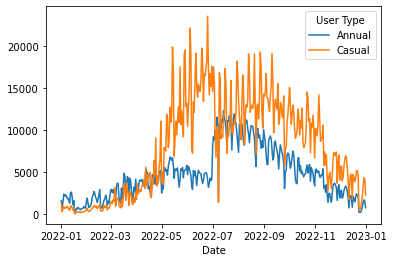

In [316]:
# Group by `Date` to see the yearly trend for annual and casual members
user.groupby(['Date', 'User Type'])['User Type'].count().unstack().plot();

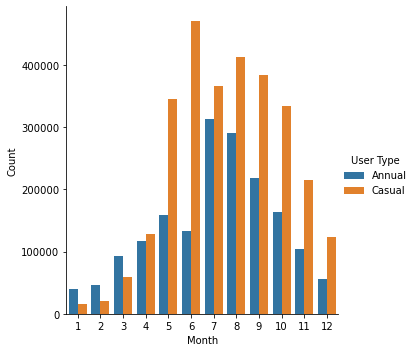

In [317]:
# Group by `Month` to see the yearly trend for annual and casual members
user_by_month = user.groupby(['Month', 'User Type'])['User Type'].count().reset_index(name='Count')
sns.catplot(data=user_by_month, kind='bar',
            x='Month', y='Count', hue='User Type');

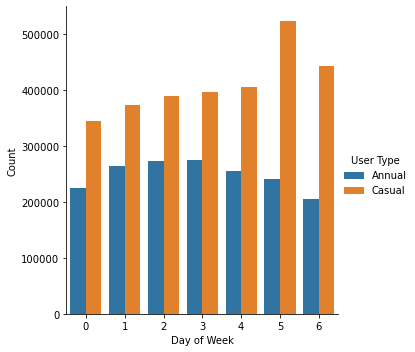

In [318]:
# Group by `Day of Week` to see the yearly trend for annual and casual members
user_by_month = user.groupby(['Day of Week', 'User Type'])['User Type'].count().reset_index(name='Count')
sns.catplot(data=user_by_month, kind='bar',
            x='Day of Week', y='Count', hue='User Type');

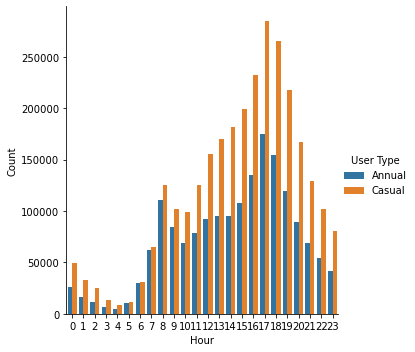

In [319]:
# Group by `Day of Week` to see the yearly trend for annual and casual members
user_by_month = user.groupby(['Hour', 'User Type'])['User Type'].count().reset_index(name='Count')
sns.catplot(data=user_by_month, kind='bar',
            x='Hour', y='Count', hue='User Type');

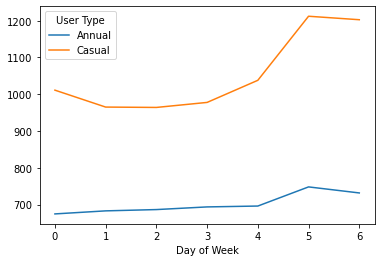

In [373]:
user.groupby(['Day of Week', 'User Type'])['Duration'].mean().unstack().plot();

In [258]:
# Load into database
# engine = create_engine(f"sqlite:///bst.sqlite")
# connection = engine.connect()
# user_summary.to_sql('user', connection, if_exists='replace')

## `Bike Id`

In [321]:
df_2

,Start Time,End Time,Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,Bike Id,User Type
0,2022-01-01 00:02:00,2022-01-01 01:15:00,4335,7334,Simcoe St / Wellington St North,7269,Toronto Eaton Centre (Yonge St),5139,Casual
1,2022-01-01 00:02:00,2022-01-01 00:05:00,126,7443,Dundas St E / George St,7270,Church St / Dundas St E - SMART,3992,Annual
2,2022-01-01 00:04:00,2022-01-01 00:19:00,942,7399,Lower Jarvis / Queens Quay E,7686,NaN,361,Annual
3,2022-01-01 00:04:00,2022-01-01 01:15:00,4256,7334,Simcoe St / Wellington St North,7269,Toronto Eaton Centre (Yonge St),4350,Casual
4,2022-01-01 00:05:00,2022-01-01 01:17:00,4353,7334,Simcoe St / Wellington St North,7038,Dundas St W / Yonge St,5074,Casual
...,...,...,...,...,...,...,...,...,...
4620464,2022-12-31 23:58:00,2023-01-01 00:45:00,2825,7374,Frederick St / The Esplanade,7048,Front St W / Yonge St (Hockey Hall of Fame),788,Casual
4620465,2022-12-31 23:58:00,2023-01-01 00:27:00,1764,7029,Bay St / Bloor St W (East Side),7164,Gould St / Yonge St (Ryerson University),536,Casual
4620466,2022-12-31 23:58:00,2023-01-01 00:06:00,469,7713,NaN,7028,Gould St / Mutual St,6306,Casual
4620467,2022-12-31 23:59:00,2023-01-01 00:09:00,588,7130,Davenport Rd / Bedford Rd,7012,Elizabeth St / Edward St (Bus Terminal),3182,Casual


In [322]:
def bike_agg(x):
    features ={
        # Stagnation
        'First Pickup': x['Start Time'].min(),
        'Last Dropoff': x['End Time'].max(),
        'Service Period': x['End Time'].max() - x['Start Time'].min(),
        'Total Usage': x['Duration'].sum(),
        'Total Trips': x['Duration'].count(),
        'Longest Trip': x['Duration'].max(),
        'Shortest Trip': x['Duration'].min(),
        'Average Trip': x['Duration'].mean()
    }
    return pd.Series(features, index=features.keys())

bike = df_2.groupby('Bike Id').apply(bike_agg)

In [323]:
bike

,First Pickup,Last Dropoff,Service Period,Total Usage,Total Trips,Longest Trip,Shortest Trip,Average Trip
Bike Id,,,,,,,,
15,2022-01-01 15:15:00,2022-12-07 15:49:00,340 days 00:34:00,335019,440,15177,70,761.406818
16,2022-01-04 16:01:00,2022-11-05 18:09:00,305 days 02:08:00,529038,547,36757,98,967.162706
17,2022-01-29 14:38:00,2022-12-27 11:47:00,331 days 21:09:00,174547,206,10252,69,847.315534
18,2022-01-05 08:33:00,2022-12-31 21:43:00,360 days 13:10:00,636011,645,53856,65,986.063566
19,2022-01-07 10:57:00,2022-12-30 14:52:00,357 days 03:55:00,555894,563,14161,61,987.378330
...,...,...,...,...,...,...,...,...
7259,2022-08-05 18:27:00,2022-12-21 09:20:00,137 days 14:53:00,585248,537,12466,66,1089.847300
7260,2022-08-04 01:47:00,2022-12-27 05:27:00,145 days 03:40:00,649029,513,44268,74,1265.163743
7261,2022-08-04 18:32:00,2022-11-28 16:05:00,115 days 21:33:00,496988,480,12107,66,1035.391667


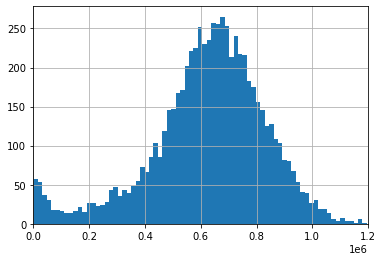

In [324]:
bike['Total Usage'].hist(bins=100)
plt.xlim([0, 1.2e6]);

In [325]:
# One really cool feature would be to select a bike ID from the database and show all the logged activites on an open map.
# However, consider this: 6800 bikes and 4 million records...
bike.loc[513]

First Pickup      2022-12-30 10:36:00
Last Dropoff      2022-12-30 11:06:00
Service Period        0 days 00:30:00
Total Usage                      1803
Total Trips                         1
Longest Trip                     1803
Shortest Trip                    1803
Average Trip                   1803.0
Name: 513, dtype: object

In [327]:
bike['Total Trips'].sort_values()

Bike Id
1986       1
1253       1
513        1
2186       2
2390       2
        ... 
6005    1235
6070    1237
5427    1300
6839    1339
6775    1418
Name: Total Trips, Length: 6829, dtype: int64

In [260]:
# engine = create_engine(f"sqlite:///bst2022.sqlite")
# connection = engine.connect()
# bike.to_sql('bike', connection, if_exists='replace')

## Stage 3: All about station ids

In [329]:
df_2.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4609635 entries, 0 to 4620468
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   Start Time          4609635 non-null  datetime64[ns]
 1   End Time            4609635 non-null  datetime64[ns]
 2   Duration            4609635 non-null  int64         
 3   Start Station Id    4609635 non-null  int64         
 4   Start Station Name  4426570 non-null  object        
 5   End Station Id      4609602 non-null  Int64         
 6   End Station Name    4426353 non-null  object        
 7   Bike Id             4609635 non-null  int64         
 8   User Type           4609635 non-null  object        
dtypes: Int64(1), datetime64[ns](2), int64(3), object(3)
memory usage: 356.1+ MB


In [366]:
df_3 = df_2.copy()

In [367]:
df_3.drop(columns=['Start Station Name', 'End Station Name'], inplace=True)
df_3.dropna(inplace=True)

In [368]:
df_3.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4609602 entries, 0 to 4620468
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Start Time        4609602 non-null  datetime64[ns]
 1   End Time          4609602 non-null  datetime64[ns]
 2   Duration          4609602 non-null  int64         
 3   Start Station Id  4609602 non-null  int64         
 4   End Station Id    4609602 non-null  Int64         
 5   Bike Id           4609602 non-null  int64         
 6   User Type         4609602 non-null  object        
dtypes: Int64(1), datetime64[ns](2), int64(3), object(1)
memory usage: 285.7+ MB


In [369]:
# Compute how many stations are missing coord info if we want to map the results downstream through Leaflet
station_id = df_3['Start Station Id'].unique()
missing_station_id = []
for i in station_id:
    if i not in station_ids_todate:
        missing_station_id.append(i)
len(missing_station_id)

38

In [370]:
# How many records have station IDs missing in the todate info?
missing_start = df_3['Start Station Id'].isin(missing_station_id)
missing_end = df_3['End Station Id'].isin(missing_station_id)
print(f'{(missing_start | missing_end).sum()/len(df_3):.1%} of records would be removed if we proceeded with the latest station info.')

8.3% of records would be removed if we proceeded with the latest station info.


In [371]:
df_3 = df_3[(~missing_start) & (~missing_end)]
df_3

,Start Time,End Time,Duration,Start Station Id,End Station Id,Bike Id,User Type
0,2022-01-01 00:02:00,2022-01-01 01:15:00,4335,7334,7269,5139,Casual
1,2022-01-01 00:02:00,2022-01-01 00:05:00,126,7443,7270,3992,Annual
2,2022-01-01 00:04:00,2022-01-01 00:19:00,942,7399,7686,361,Annual
3,2022-01-01 00:04:00,2022-01-01 01:15:00,4256,7334,7269,4350,Casual
4,2022-01-01 00:05:00,2022-01-01 01:17:00,4353,7334,7038,5074,Casual
...,...,...,...,...,...,...,...
4620464,2022-12-31 23:58:00,2023-01-01 00:45:00,2825,7374,7048,788,Casual
4620465,2022-12-31 23:58:00,2023-01-01 00:27:00,1764,7029,7164,536,Casual
4620466,2022-12-31 23:58:00,2023-01-01 00:06:00,469,7713,7028,6306,Casual
4620467,2022-12-31 23:59:00,2023-01-01 00:09:00,588,7130,7012,3182,Casual


In [347]:
df_3[~df_3['End Station Id'].isin(missing_station_id)]

,Start Time,End Time,Duration,Start Station Id,End Station Id,Bike Id,User Type
0,2022-01-01 00:02:00,2022-01-01 01:15:00,4335,7334,7269,5139,Casual
1,2022-01-01 00:02:00,2022-01-01 00:05:00,126,7443,7270,3992,Annual
2,2022-01-01 00:04:00,2022-01-01 00:19:00,942,7399,7686,361,Annual
3,2022-01-01 00:04:00,2022-01-01 01:15:00,4256,7334,7269,4350,Casual
4,2022-01-01 00:05:00,2022-01-01 01:17:00,4353,7334,7038,5074,Casual
...,...,...,...,...,...,...,...
4620464,2022-12-31 23:58:00,2023-01-01 00:45:00,2825,7374,7048,788,Casual
4620465,2022-12-31 23:58:00,2023-01-01 00:27:00,1764,7029,7164,536,Casual
4620466,2022-12-31 23:58:00,2023-01-01 00:06:00,469,7713,7028,6306,Casual
4620467,2022-12-31 23:59:00,2023-01-01 00:09:00,588,7130,7012,3182,Casual
